In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path
sys.path.append('../scenes/')
import syndiff as sd 

In [2]:
ra = 299.6193292     
dec = 62.1377889
# host fqv
#ra = 189.1428830     
#dec = 11.2386300
size = 15
filts = ['g','r','i','z','y']
ps1 = sd.PS1_images(ra,dec,size,filts)
tpf = sd.Get_TESS(ra,dec,14,)

../scenes/ps1_funcs.py:183: RuntimeWarning: invalid value encountered in log10
  m = -2.5*np.log10(ima) + 25 + 2.5*np.log10(im.header['EXPTIME'])
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
/Users/rridden/miniconda3/lib/python3.7/site-packages/lightkurve/search.py:233: LightkurveWarning: Warning: 7 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning)


In [3]:
iprf = sd.Interp_PRF(tpf.row,tpf.column,tpf.camera,tpf.ccd,100)
prf = sd.Get_PRF(tpf.row,tpf.column,tpf.camera,tpf.ccd)

<IPython.core.display.Javascript object>


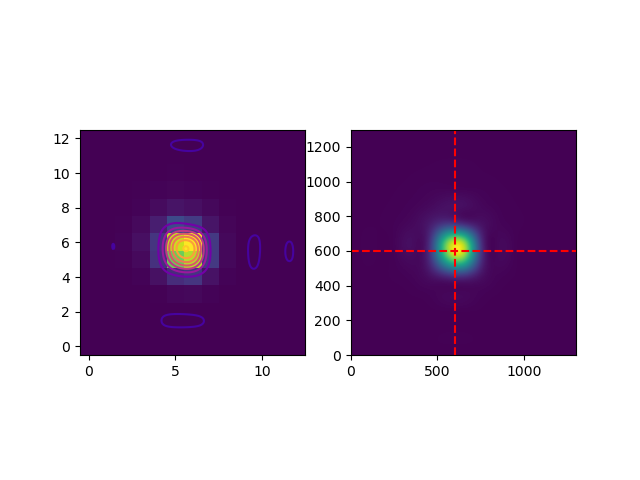

In [4]:
plt.figure()
plt.subplot(121)
plt.imshow(prf,origin='lower')
plt.contour(iprf,extent=(-0.5,12.5,-0.5,12.5),cmap='plasma')
plt.subplot(122)
plt.imshow(iprf,origin='lower')
plt.axvline(600,ls='--',color='r')
plt.axhline(600,ls='--',color='r')

In [5]:
iprf.shape

(1300, 1300)

<IPython.core.display.Javascript object>


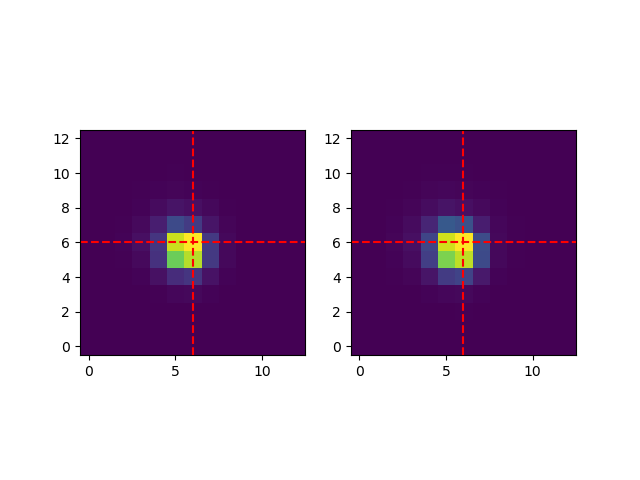

In [4]:
d = sd.Downsample(iprf,100,pix_response=False)
plt.figure()
plt.subplot(121)
plt.imshow(prf/np.nanmax(prf),origin='lower',cmap='viridis')
#plt.contour(iprf,extent=(-0.5,12.5,-0.5,12.5),cmap='plasma')
plt.axvline(6,ls='--',color='r')
plt.axhline(6,ls='--',color='r')
plt.subplot(122)
plt.imshow(d/np.nanmax(d),origin='lower',cmap='viridis')
plt.axvline(6,ls='--',color='r')
plt.axhline(6,ls='--',color='r')

The interpolation is shifting the psf, not good! 

# Try photutils

In [19]:
from photutils.detection import IRAFStarFinder
from photutils.psf import IntegratedGaussianPRF, DAOGroup
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm

In [95]:
sigma_psf = 1.0
bkgrms = MADStdBackgroundRMS()
std = bkgrms(prf)
iraffind = IRAFStarFinder(threshold=3.5*std,
                       fwhm=sigma_psf*gaussian_sigma_to_fwhm,
                       minsep_fwhm=0.01, roundhi=5.0, roundlo=-5.0,
                       sharplo=0.0, sharphi=2.0)
daogroup = DAOGroup(2.0*sigma_psf*gaussian_sigma_to_fwhm)
mmm_bkg = MMMBackground()
fitter = LevMarLSQFitter()
psf_model = IntegratedGaussianPRF(sigma=sigma_psf)
from photutils.psf import IterativelySubtractedPSFPhotometry
photometry = IterativelySubtractedPSFPhotometry(finder=iraffind,
                                             group_maker=daogroup,
                                             bkg_estimator=mmm_bkg,
                                             psf_model=psf_model,
                                             fitter=LevMarLSQFitter(),
                                             niters=1, fitshape=(11,11))
result_tab = photometry(image=prf)
residual_image = photometry.get_residual_image()

<IPython.core.display.Javascript object>


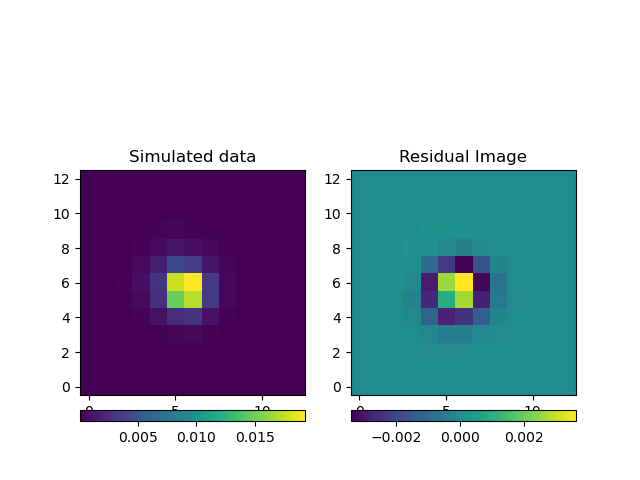

In [96]:
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(prf, cmap='viridis', aspect=1, interpolation='nearest',
               origin='lower')
plt.title('Simulated data')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)
plt.subplot(1 ,2, 2)
plt.imshow(residual_image, cmap='viridis', aspect=1,
            interpolation='nearest', origin='lower')
plt.title('Residual Image')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)

In [97]:
x,y = np.meshgrid(np.arange(0-6,13-6,0.1),np.arange(0-6,13-6,0.1))

In [98]:
z = psf_model(x,y)

<IPython.core.display.Javascript object>


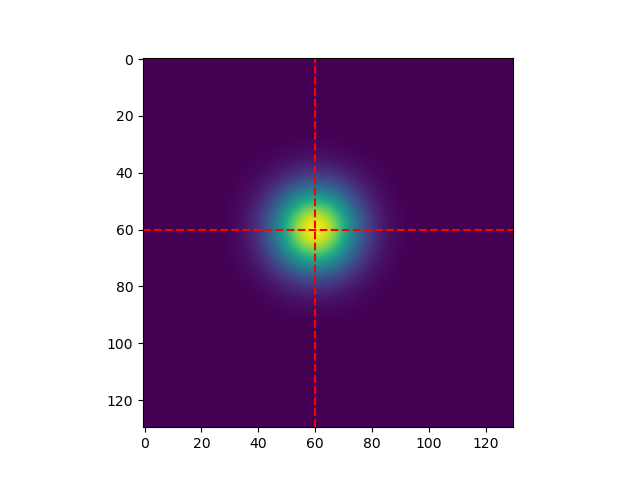

In [99]:
plt.figure()
plt.imshow(z)#,extent=(-.5,12.5,-.5,12.5))
plt.axvline(60,ls='--',color='r')
plt.axhline(60,ls='--',color='r')

In [79]:
prf.shape

(13, 13)

In [81]:
z.shape

(12, 12)

In [ ]:
psf_model.x_0.fixed = True
>>> psf_model.y_0.fixed = True
>>> pos = Table(names=['x_0', 'y_0'], data=[sources['x_mean'],
...                                         sources['y_mean']])
photometry = BasicPSFPhotometry(group_maker=daogroup,
...                                 bkg_estimator=mmm_bkg,
...                                 psf_model=psf_model,
...                                 fitter=LevMarLSQFitter(),
...                                 fitshape=(11,11))
>>> result_tab = photometry(image=image, init_guesses=pos)
>>> residual_image = photometry.get_residual_image()